In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"  # specify which GPU(s) to be used

In [2]:
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '../src')

from dataset import DatasetConfig, DatasetBuilder
import os
from functools import partial
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from collections import defaultdict, namedtuple
from typing import Callable, Dict, List, Tuple
from trainer import Trainer, TrainerConfig
import jax
import jax.numpy as jnp
%matplotlib inline

plt.rcParams["figure.figsize"] = (10, 10)

In [3]:
from read_write_model import read_model, qvec2rotmat
import numpy as np

cameras, images, points3D = read_model('../dataset/pinecone/sparse/0/', ext=".bin")

In [130]:
np.array(points3D.values())

KeyboardInterrupt: 

In [121]:
image_meta = images[1]
points_2d = image_meta.xys
points_idx = image_meta.point3D_ids
valid_idx = points_idx != -1
points_2d = points_2d[valid_idx]
points_idx = points_idx[valid_idx]
weights = np.array([points3D[idx].error for idx in points_idx])

In [123]:
weights.shape

(5072,)

In [128]:
tf.convert_to_tensor(weights[..., None])

<tf.Tensor: shape=(5072, 1), dtype=float64, numpy=
array([[0.95010879],
       [2.27108173],
       [0.49718864],
       ...,
       [2.24264669],
       [1.85001739],
       [2.45816851]])>

In [68]:
points3D[images[1].point3D_ids[idx][0]]

Point3D(id=46215, xyz=array([-0.35774539, -0.68893584,  4.93894376]), rgb=array([0, 0, 0]), error=array(0.95010879), image_ids=array([5, 4, 3, 2, 1]), point2D_idxs=array([1003,  683,  364,  168,   26]))

In [35]:
jnp.ones_like(x) * jnp.nan

DeviceArray([[nan, nan, nan],
             [nan, nan, nan],
             [nan, nan, nan]], dtype=float32)

In [29]:
points3D[1]

Point3D(id=1, xyz=array([ 0.80476486, -3.12924099,  5.51971731]), rgb=array([0, 0, 0]), error=array(0.24492585), image_ids=array([11, 13]), point2D_idxs=array([1, 3]))

In [ ]:
points3D[]

In [9]:
from typing import Union, NamedTuple

class Rays(NamedTuple):
    origins: Union[tf.Tensor, np.ndarray, jnp.ndarray]
    directions: Union[tf.Tensor, np.ndarray, jnp.ndarray]
    colors: Union[tf.Tensor, np.ndarray, jnp.ndarray]
    depth: Union[tf.Tensor, np.ndarray, jnp.ndarray] = jnp.nan
    weights: Union[tf.Tensor, np.ndarray, jnp.ndarray] = jnp.nan

21.486677055282442


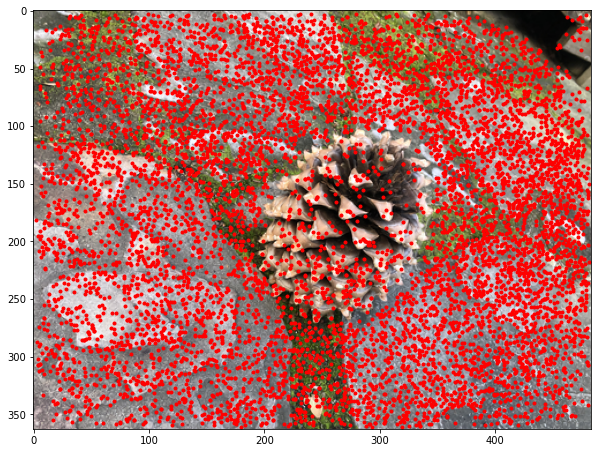

In [109]:
iid = 30
idx = images[iid].point3D_ids
points = []
for i in idx:
    if i != -1:
        points.append(points3D[i].xyz)
        
points = np.array(points)
rotation = qvec2rotmat(images[iid].qvec)
points_cam = (np.matmul(rotation, points.T) + images[iid].tvec[..., np.newaxis]).T

camera = cameras[images[iid].camera_id]
focal, cx, cy, _ = camera.params
intrinsics = np.eye(3)

ratio = 4032 / 484
intrinsics[0, 0] = focal / ratio
intrinsics[1, 1] = focal / ratio
intrinsics[0, -1] = cx / ratio
intrinsics[1, -1] = cy / ratio

pixels = np.matmul(intrinsics, points_cam.T).T
pixels = pixels[..., :2] / pixels[..., -1:]

img_path = os.path.join('../dataset/pinecone/images_8/', images[iid].name)
img = tf.image.decode_image(tf.io.read_file(img_path.replace('JPG', 'png')), channels=3)

plt.imshow(img)
_ = plt.plot(pixels[..., 0], pixels[..., 1], 'r.')

z = points_cam[..., -1]
print(np.max(z))

In [3]:
def positional_encoding(x: jnp.ndarray, min_deg: int, max_deg: int):
    if min_deg == max_deg:
        return x
    scales = jnp.array([2**i for i in range(min_deg, max_deg)])
    print(scales.shape, x.shape)
    xb = jnp.reshape(x[..., jnp.newaxis, :] * scales[:, jnp.newaxis], list(x.shape[:-1]) + [-1])
    print(xb.shape)
    four_feat = jnp.sin(jnp.concatenate([xb, xb + 0.5 * jnp.pi], axis=-1))
    return jnp.concatenate([x] + [four_feat], axis=-1)


x = np.random.rand(100, 50, 3)
# x = data[0].directions[0][:, np.newaxis, :]
encode0 = positional_encoding(x, 0, 10)
encode0

(10,) (100, 50, 3)
(100, 50, 30)


DeviceArray([[[ 0.3908614 ,  0.00992382,  0.20904277, ...,  0.5890669 ,
                0.3603179 ,  0.97681695],
              [ 0.94126767,  0.8178973 ,  0.686561  , ..., -0.30069494,
               -0.5965432 ,  0.9430389 ],
              [ 0.48943815,  0.19888982,  0.4273288 , ...,  0.7417792 ,
                0.26690075,  0.43645802],
              ...,
              [ 0.07393029,  0.75054467,  0.85960245, ...,  0.9882886 ,
                0.53645086,  0.95724064],
              [ 0.9884186 ,  0.87389433,  0.2562021 , ..., -0.9627234 ,
                0.24066386,  0.71692777],
              [ 0.74163985,  0.29945192,  0.52456146, ..., -0.91587985,
               -0.8146599 , -0.03069264]],

             [[ 0.9221823 ,  0.04363114,  0.86749196, ...,  0.60704863,
               -0.9400574 , -0.3704303 ],
              [ 0.50680184,  0.3453336 ,  0.00384784, ..., -0.2966229 ,
                0.6359001 , -0.38877323],
              [ 0.24131976,  0.23550992,  0.44279468, ..., -0.51172

In [13]:
x.shape, encode0.shape

((100, 50, 3), (100, 50, 63))

In [5]:
np.isclose(encode0, encode1)

array([[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  Tr

In [4]:
def posenc(x, min_deg, max_deg, legacy_posenc_order=False):
  """Cat x with a positional encoding of x with scales 2^[min_deg, max_deg-1].
  Instead of computing [sin(x), cos(x)], we use the trig identity
  cos(x) = sin(x + pi/2) and do one vectorized call to sin([x, x+pi/2]).
  Args:
    x: jnp.ndarray, variables to be encoded. Note that x should be in [-pi, pi].
    min_deg: int, the minimum (inclusive) degree of the encoding.
    max_deg: int, the maximum (exclusive) degree of the encoding.
    legacy_posenc_order: bool, keep the same ordering as the original tf code.
  Returns:
    encoded: jnp.ndarray, encoded variables.
  """
  if min_deg == max_deg:
    return x
  scales = jnp.array([2**i for i in range(min_deg, max_deg)])
  print(scales.shape)
  if legacy_posenc_order:
    xb = x[Ellipsis, None, :] * scales[:, None]
    four_feat = jnp.reshape(
        jnp.sin(jnp.stack([xb, xb + 0.5 * jnp.pi], -2)),
        list(x.shape[:-1]) + [-1])
  else:
    xb = jnp.reshape((x[Ellipsis, None, :] * scales[:, None]),
                     list(x.shape[:-1]) + [-1])
    print(xb)
    four_feat = jnp.sin(jnp.concatenate([xb, xb + 0.5 * jnp.pi], axis=-1))
  return jnp.concatenate([x] + [four_feat], axis=-1)
             
# x = jnp.array([[0, 0, 1]])[:, jnp.newaxis, :]
# x = data[0].directions[0]
encode1 = posenc(x, 0, 10)
encode1

(10,)
[[[3.90861392e-01 9.92382318e-03 2.09042773e-01 ... 2.00121033e+02
   5.08099747e+00 1.07029900e+02]
  [9.41267669e-01 8.17897320e-01 6.86560988e-01 ... 4.81929047e+02
   4.18763428e+02 3.51519226e+02]
  [4.89438146e-01 1.98889822e-01 4.27328795e-01 ... 2.50592331e+02
   1.01831589e+02 2.18792343e+02]
  ...
  [7.39302859e-02 7.50544667e-01 8.59602451e-01 ... 3.78523064e+01
   3.84278870e+02 4.40116455e+02]
  [9.88418579e-01 8.73894334e-01 2.56202102e-01 ... 5.06070312e+02
   4.47433899e+02 1.31175476e+02]
  [7.41639853e-01 2.99451917e-01 5.24561465e-01 ... 3.79719604e+02
   1.53319382e+02 2.68575470e+02]]

 [[9.22182322e-01 4.36311439e-02 8.67491961e-01 ... 4.72157349e+02
   2.23391457e+01 4.44155884e+02]
  [5.06801844e-01 3.45333606e-01 3.84784373e-03 ... 2.59482544e+02
   1.76810806e+02 1.97009599e+00]
  [2.41319761e-01 2.35509917e-01 4.42794681e-01 ... 1.23555717e+02
   1.20581078e+02 2.26710876e+02]
  ...
  [6.33231819e-01 2.04646751e-01 3.12009573e-01 ... 3.24214691e+02
   1

DeviceArray([[[ 0.3908614 ,  0.00992382,  0.20904277, ...,  0.5890669 ,
                0.3603179 ,  0.97681695],
              [ 0.94126767,  0.8178973 ,  0.686561  , ..., -0.30069494,
               -0.5965432 ,  0.9430389 ],
              [ 0.48943815,  0.19888982,  0.4273288 , ...,  0.7417792 ,
                0.26690075,  0.43645802],
              ...,
              [ 0.07393029,  0.75054467,  0.85960245, ...,  0.9882886 ,
                0.53645086,  0.95724064],
              [ 0.9884186 ,  0.87389433,  0.2562021 , ..., -0.9627234 ,
                0.24066386,  0.71692777],
              [ 0.74163985,  0.29945192,  0.52456146, ..., -0.91587985,
               -0.8146599 , -0.03069264]],

             [[ 0.9221823 ,  0.04363114,  0.86749196, ...,  0.60704863,
               -0.9400574 , -0.3704303 ],
              [ 0.50680184,  0.3453336 ,  0.00384784, ..., -0.2966229 ,
                0.6359001 , -0.38877323],
              [ 0.24131976,  0.23550992,  0.44279468, ..., -0.51172

In [112]:
z_value = []
for iid in images.keys():
    idx = images[iid].point3D_ids
    points = []
    for i in idx:
        if i != -1:
            points.append(points3D[i].xyz)

    points = np.array(points)
    rotation = qvec2rotmat(images[iid].qvec)
    points_cam = (np.matmul(rotation, points.T) + images[iid].tvec[..., np.newaxis]).T
    z_value.append(points_cam[..., -1])

In [117]:
np.min(np.concatenate(z_value, axis=0))

2.6253142029170107

In [81]:
img = tf.image.decode_image(tf.io.read_file(img_path), channels=3)

In [94]:
img.shape

TensorShape([363, 484, 3])

In [95]:
camera

Camera(id=1, model='SIMPLE_RADIAL', width=4032, height=3024, params=array([3.34624313e+03, 2.01600000e+03, 1.51200000e+03, 6.98396644e-03]))

In [96]:
4032 / 484

8.330578512396695

In [3]:
ds_config =  DatasetConfig(model_dir='../dataset/pinecone/sparse/0/',
                           images_dir='../dataset/pinecone/images_8/',
                           batch_from_single_image=True,
                           train_batch_size=8, test_batch_size=-1)
trainer_config = TrainerConfig(dataset_config=ds_config)

In [4]:
trainer = Trainer(trainer_config)
train_iter, val_iter = trainer.create_dataset()

In [6]:
data = []
for step, rays in zip(range(1), train_iter):
    data.append(rays)

In [19]:
data[0]

Rays(origins=ShardedDeviceArray([[[-1.9229347, -3.0000927,  3.3044224],
                     [-1.9229347, -3.0000927,  3.3044224]]],                   dtype=float32), directions=ShardedDeviceArray([[[0.41802984, 0.74335635, 0.5221644 ],
                     [0.34140566, 0.47233826, 0.8126053 ]]],                   dtype=float32), colors=ShardedDeviceArray([[[0.47058827, 0.48627454, 0.47058827],
                     [0.627451  , 0.60784316, 0.6039216 ],
                     [0.34509805, 0.35686275, 0.2784314 ],
                     [1.        , 1.        , 1.        ]]],                   dtype=float32), depth=None, weights=None)

In [10]:
tmp._numpy()

array([[nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
      

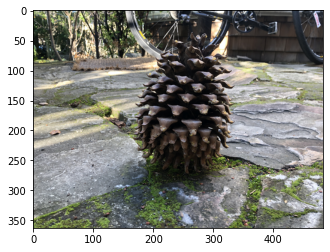

In [13]:
img = np.reshape(data[0].colors, [363, 484, 3])
plt.imshow(img)

In [16]:
np.min(img)

DeviceArray(0., dtype=float32)

In [9]:
lines = []
colors = []

def make_line(origin, direction, length=10):
    return origin, origin + direction * length

for elements in train_iter:
    origins = elements.origins
    directions = elements.directions
    pixels = elements.colors
    N = origins.shape[0]
    for i in range(N):
        p0, p1 = make_line(origins[i, ...], directions[i, ...])
        lines.append(p0)
        lines.append(p1)
        colors.append(pixels[i, ...])

UnknownError: NotFoundError: ../dataset/pinecone/images_8/IMG_7238.JPG; No such file or directory [Op:ReadFile]
Traceback (most recent call last):

  File "/home/liangkai/.local/lib/python3.6/site-packages/tensorflow/python/ops/script_ops.py", line 247, in __call__
    return func(device, token, args)

  File "/home/liangkai/.local/lib/python3.6/site-packages/tensorflow/python/ops/script_ops.py", line 135, in __call__
    ret = self._func(*args)

  File "/home/liangkai/.local/lib/python3.6/site-packages/tensorflow/python/autograph/impl/api.py", line 645, in wrapper
    return func(*args, **kwargs)

  File "../src/dataset.py", line 82, in _parse_single_image
    image = tf.image.decode_image(tf.io.read_file(image_filename), channels=3)

  File "/home/liangkai/.local/lib/python3.6/site-packages/tensorflow/python/ops/io_ops.py", line 139, in read_file
    return gen_io_ops.read_file(filename, name)

  File "/home/liangkai/.local/lib/python3.6/site-packages/tensorflow/python/ops/gen_io_ops.py", line 556, in read_file
    filename, name=name, ctx=_ctx)

  File "/home/liangkai/.local/lib/python3.6/site-packages/tensorflow/python/ops/gen_io_ops.py", line 579, in read_file_eager_fallback
    attrs=_attrs, ctx=ctx, name=name)

  File "/home/liangkai/.local/lib/python3.6/site-packages/tensorflow/python/eager/execute.py", line 60, in quick_execute
    inputs, attrs, num_outputs)

tensorflow.python.framework.errors_impl.NotFoundError: ../dataset/pinecone/images_8/IMG_7238.JPG; No such file or directory [Op:ReadFile]


	 [[{{node EagerPyFunc}}]] [Op:IteratorGetNext]

In [8]:
elements

ColoredRays(origins=array([[-1.3584163,  2.8891244, -0.7654388],
       [-1.3584163,  2.8891244, -0.7654388],
       [-1.3584163,  2.8891244, -0.7654388],
       [-1.3584163,  2.8891244, -0.7654388],
       [-1.3584163,  2.8891244, -0.7654388],
       [-1.3584163,  2.8891244, -0.7654388],
       [-1.3584163,  2.8891244, -0.7654388],
       [-1.3584163,  2.8891244, -0.7654388]], dtype=float32), directions=array([[ 0.21775223,  0.36321905,  0.9058935 ],
       [ 0.48083252,  0.4632607 ,  0.74443144],
       [ 0.67416   ,  0.4551204 ,  0.5816901 ],
       [ 0.19054098,  0.37953192,  0.9053382 ],
       [ 0.5216486 ,  0.24016047,  0.8186518 ],
       [ 0.5905296 , -0.33727977,  0.7331424 ],
       [ 0.46349207,  0.44260776,  0.7676338 ],
       [ 0.3815262 , -0.24660194,  0.89084554]], dtype=float32), colors=array([[0.69411767, 0.6745098 , 0.69803923],
       [0.26666668, 0.30980393, 0.18431373],
       [0.30588236, 0.3137255 , 0.3019608 ],
       [0.654902  , 0.65882355, 0.6666667 ],
    

In [7]:
data = np.asarray(lines)
np.save('lines.npy', data)

colors = np.asarray(colors)
np.save('colors.npy', colors)

In [9]:
from read_write_model import read_model, qvec2rotmat

In [10]:
cameras_meta, images_meta, points = read_model("../dataset/pinecone/sparse/0/", ext=".bin")

In [15]:
cameras_meta[1].params

array([3.34624313e+03, 2.01600000e+03, 1.51200000e+03, 6.98396644e-03])

In [22]:
R = qvec2rotmat(images_meta[1].qvec)

In [24]:
from scipy.spatial.transform import Rotation as R

In [25]:
r = R.from_quat(images_meta[1].qvec)

In [33]:
r.as_matrix()

array([[ 0.49530899,  0.27762036, -0.82316216],
       [-0.22033811, -0.87642766, -0.42816547],
       [-0.84030954,  0.3934482 , -0.37293215]])

In [32]:
r.as_rotvec()

array([ 2.2577188 ,  0.04711942, -1.36834409])

In [21]:
images_meta[1]

Image(id=1, qvec=array([ 0.8283521 ,  0.01728801, -0.50204246,  0.24796631]), tvec=array([2.83913768, 0.04884715, 2.37824897]), camera_id=1, name='IMG_7238.JPG', xys=array([[1814.70959473,    5.92477465],
       [2477.25439453,    7.72096825],
       [ 710.68273926,   11.48809433],
       ...,
       [2755.18774414, 1459.08056641],
       [2755.18774414, 1459.08056641],
       [3617.06396484, 1057.89892578]]), point3D_ids=array([-1, -1, -1, ..., -1, -1, -1]))